In [ ]:
# Loading in all packages
import gimmemotifs
from gimmemotifs.preprocessing import combine_peaks
from gimmemotifs.preprocessing import coverage_table
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import seaborn as sns
import subprocess as sp
import qnorm  # either add qnorm to the yml, or run conda install qnorm in the env
#import gseapy as gp
#from gseapy.plot import barplot, dotplot
import itertools
import ipywidgets

os.chdir("/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/markdown_notebooks/scripts")
from Python_scripts import bedtool_closest
from Python_scripts import coverage_table_normalization
from Python_scripts import genome_TSS_annotation
from Python_scripts import genome_TSS_annotation_prom
from Python_scripts import make_autopct
from Python_scripts import summits_2_regions
from Python_scripts import distance_weight

plt.style.use("classic")
%matplotlib inline
#%load_ext nb_black
#%reload_ext nb_black
os.chdir("/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/tools/scripts")
from Python_scripts import TSS_to_region

In [1]:
"""
# ipython_exit.py
Allows exit() to work if script is invoked with IPython without
raising NameError Exception. Keeps kernel alive.

Use: import variable 'exit' in target script with 'from ipython_exit import exit'    
"""

import sys
from io import StringIO
from IPython import get_ipython


class IpyExit(SystemExit):
    """Exit Exception for IPython.

    Exception temporarily redirects stderr to buffer.
    """
    def __init__(self):
        # print("exiting")  # optionally print some message to stdout, too
        # ... or do other stuff before exit
        sys.stderr = StringIO()

    def __del__(self):
        sys.stderr.close()
        sys.stderr = sys.__stderr__  # restore from backup


def ipy_exit():
    raise IpyExit


if get_ipython():    # ...run with IPython
    exit = ipy_exit  # rebind to custom exit
else:
    exit = exit      # just make exit importable

In [4]:
ID_CREs = Identify_differential_CREs(
    datapaths_file="/ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data/lako2021/merge_peaks/files2.tsv",
    config_file="/ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data/lako2021/merge_peaks/config.tsv",
    output_dir="/ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data/lako2021/merge_peaks/2021-08-04",
    notebook_file="/ceph/rimlsfnwi/data/moldevbio/zhou/jarts/jupyter_notebooks/Combine_peaks.ipynb",
)

ID_CREs.main_dir = (
    "/ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data/lako2021/merge_peaks/"
)
# datapaths_file="/ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data/lako2021/merge_peaks/files.tsv" for all 11 populations

In [29]:
#Merging peaks and generating individual count files
merged_summits = list()
if not os.path.exists(f"{ID_CREs.output_dir}/accesible_summits_reps.bed"):
    ATAC_BAM = ID_CREs.files[ID_CREs.files.data_type == "ATAC_BAM"]
    ATAC_BAM = ATAC_BAM.file_location
    ATAC_peaks = ID_CREs.files[ID_CREs.files.data_type == "ATAC_peak"]
    ATAC_pfiles = ATAC_peaks.file_location 
    combined_ATAC_peaks = combine_peaks(
        list(ATAC_pfiles),
        #print(list(ATAC_pfiles)),
        ID_CREs.files.loc["genome_path_size", :].file_location,
        ID_CREs.config.loc["ATAC_summit", :].vallue,
        True,
    )
    combined_ATAC_peaks.to_csv(
        f"{ID_CREs.tmpdir}/all_merged_ATAC_peaks_reps.bed",
        sep="\t",
        header=False,
        index=False,
    )

    # quantify the peak intensity per cell type
    cell_types = np.unique(
        ID_CREs.files[ID_CREs.files.data_type == "ATAC_BAM"].cell_type,
        return_index=False,
    )
    print(cell_types)
    for cell in cell_types:
        print(cell)
        ATAC_BAM = ID_CREs.files[ID_CREs.files.data_type == "ATAC_BAM"]
        ATAC_BAM = ATAC_BAM[ATAC_BAM.cell_type == cell].file_location
        print(ATAC_BAM)
        
        print("rerunning maelstrom top 100.000 ATAC peaks")
        peak_counts = coverage_table(
             peakfile=f"{ID_CREs.tmpdir}/all_merged_ATAC_peaks_reps.bed",
             datafiles=list(ATAC_BAM),
             window=int(ID_CREs.config.loc["ATAC_summit", :][0]),
             log_transform=False,
             ncpus=int(ID_CREs.config.loc["ncores", :][0]),
         )
        peak_counts = peak_counts[
             ~peak_counts.index.str.contains(
                 "|".join(["GL", "Un", "KI", "MT", "X", "Y"])
             )
         ]
        final_df = peak_counts
        final_df.index.name = "loc"
        final_df.to_csv(
            f"{ID_CREs.tmpdir}/{str(cell)}covtable.tsv",
            sep="\t",
            header=True,
            index=True,
        )

2021-08-06 10:40:46,497 - INFO - Loading data


['LiCo' 'StCSC']
LiCo
filename
LiCo_ATAC_BAM    /ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data...
Name: file_location, dtype: object
rerunning maelstrom top 100.000 ATAC peaks


  0%|          | 0/1 [00:00<?, ?it/s]

2021-08-06 10:46:04,137 - INFO - No normalization
2021-08-06 10:46:04,633 - INFO - Loading data


StCSC
filename
StCSC_ATAC_BAM    /ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data...
Name: file_location, dtype: object
rerunning maelstrom top 100.000 ATAC peaks


  0%|          | 0/1 [00:00<?, ?it/s]

2021-08-06 10:47:44,273 - INFO - No normalization


In [30]:
# Concatenating all cell files to one final file
import pandas as pd
import glob

path = f"{ID_CREs.tmpdir}/"
all_files = []

cell_types = np.unique(
        ID_CREs.files[ID_CREs.files.data_type == "ATAC_BAM"].cell_type,
        return_index=False,
    )

# Joining all cov table locations into one list
for cell in cell_types:
    print(cell)
    all_files = glob.glob(path + f"*covtable.tsv")

print(all_files)

if not os.path.exists(f"{ID_CREs.tmpdir}/joinedcovtable.tsv"):

    # Joining all files to one dataframe
    dffull = pd.concat((pd.read_table(f) for f in all_files),axis=1)

    # Merging the loc columns to one
    dffull = dffull.groupby(level=0, axis=1).first()

    # Setting loc as the index
    dffull.index = dffull['loc']
    del dffull['loc']

    dffull.to_csv(
                f"{ID_CREs.tmpdir}/joinedcovtable.tsv",
                sep="\t",
                header=True,
                index=True,
            )

    dffull

LiCo
StCSC
['/ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data/lako2021/merge_peaks/2021-08-04/tmp/StCSCcovtable.tsv', '/ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data/lako2021/merge_peaks/2021-08-04/tmp/LiCocovtable.tsv']


,LiCo,StCSC
loc,,
chr1:10167-10367,131.0,25.0
chr1:11168-11368,0.0,0.0
chr1:19044-19244,2.0,0.0
chr1:29070-29270,1.0,0.0
chr1:29426-29626,4.0,2.0
...,...,...
chr9:138256876-138257076,0.0,0.0
chr9:138277217-138277417,0.0,0.0
chr9:138287670-138287870,4.0,0.0


CLUSTER DENDROGRAM AFTER GIMMEMOTIFS

In [3]:
# cluster dendrogram
#d = np.loadtxt("/ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data/lako2021/motif_analysis/quantile_nosplit/final.out.txt", delimiter="\t")
from gimmemotifs.maelstrom import MaelstromResult
import matplotlib.pyplot as plt

mr = MaelstromResult("/ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data/lako2021/motif_analysis/quantile_nosplit/")
mr
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


In [1]:
import numpy as np
import pandas as pd
data = pd.read_csv('/ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data/lako2021/motif_analysis/quantile_nosplit/final.out.txt', sep='\t', header=0)
data

,Unnamed: 0,z-score Ves,z-score StC,z-score MEC,z-score LPCs,z-score LNPCs,z-score IC,z-score FCECs,z-score CjS,z-score CSSCs,...,corr StC,corr MEC,corr LPCs,corr LNPCs,corr IC,corr FCECs,corr CjS,corr CSSCs,corr CSB,corr CB
0,GM.5.0.Paired_box.0015,2.001462,-1.849605,-0.176631,-1.635877,-0.334819,2.410838,1.330647,0.989130,-1.649508,...,-0.008645,-0.001457,-0.008207,0.008225,0.005880,0.009235,0.009235,-0.022719,0.010249,-0.000187
1,GM.5.0.Unknown.0105,0.189169,-0.284122,0.426180,-1.076711,-1.677574,2.780130,1.367942,1.398851,-2.227670,...,-0.008681,0.003073,-0.002055,0.002049,0.010157,0.009605,0.009605,-0.024338,0.005156,-0.003239
2,GM.5.0.C2H2_ZF.0076,1.181649,1.107832,-1.247596,1.262282,0.493464,1.166888,-0.435474,-1.680566,0.088908,...,0.012974,-0.001421,0.003979,0.001943,-0.003106,-0.009987,-0.009987,0.016533,-0.014155,-0.011099
3,GM.5.0.Unknown.0202,1.277647,1.243034,1.178446,0.777869,1.452066,-0.469456,1.126831,0.804325,-1.942204,...,0.003114,0.004672,0.006945,0.007979,0.003238,0.000089,0.000089,-0.011838,-0.011727,-0.009358
4,GM.5.0.Homeodomain.0082,2.841762,3.471909,0.338991,-1.973363,0.022684,1.672579,-1.901846,-0.908538,2.188963,...,0.030816,0.000818,-0.007061,0.002304,0.001875,-0.010774,-0.010774,0.016509,-0.028183,-0.032016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614,GM.5.0.Unknown.0126,-0.367036,-0.318838,1.085637,-0.660231,0.127138,0.218868,-1.163022,-0.437099,0.422055,...,-0.000004,-0.000590,0.002508,-0.002091,-0.002844,0.006303,0.006303,0.000383,-0.002778,0.000904
615,GM.5.0.bZIP.0003,-4.034794,-2.212122,-3.784436,3.170850,3.172519,-3.186876,2.622535,2.038339,-1.389511,...,-0.059449,-0.042032,0.022691,0.034370,-0.029666,0.040173,0.040173,-0.031529,0.066674,0.088966
616,GM.5.0.GATA.0013,2.049083,2.033096,-1.515787,-0.853108,-1.736792,-0.374446,-0.601785,-0.585981,0.811501,...,0.002997,-0.000968,0.005162,0.004373,0.002083,-0.004959,-0.004959,0.000726,-0.007110,-0.000037
617,GM.5.0.Forkhead.0043,-3.136237,-4.476481,-1.925525,0.321773,0.856975,-2.418231,3.361944,2.697502,-0.212710,...,-0.031249,-0.006655,0.008066,0.017215,-0.007412,0.018132,0.018132,-0.026314,0.019469,0.023043


In [2]:
import numpy as np
from pandas import *
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

data.index = data['Unnamed: 0']
data
data2 = data[['z-score Ves','z-score StC','z-score MEC','z-score LPCs','z-score LNPCs','z-score IC','z-score FCECs','z-score CjS','z-score CSSCs','z-score CSB','z-score CB']]
data2
data2 = data2.rename(columns={'z-score Ves':'Ves', 'z-score StC': 'StC','z-score MEC':'MEC','z-score LPCs':'LPCs','z-score LNPCs':'LNPCs','z-score IC':'IC','z-score FCECs':'FCECs','z-score CjS':'CjS','z-score CSSCs':'CSSCs','z-score CSB':'CSB','z-score CB':'CB'})


In [3]:
# without the bad quality cell populations
import numpy as np
from pandas import *
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

data.index = data['Unnamed: 0']
data
data2 = data[['z-score StC','z-score MEC','z-score LPCs','z-score LNPCs','z-score CjS','z-score CSSCs','z-score CSB','z-score CB']]
data2
data2 = data2.rename(columns={'z-score StC': 'StC','z-score MEC':'MEC','z-score LPCs':'LPCs','z-score LNPCs':'LNPCs','z-score CjS':'CjS','z-score CSSCs':'CSSCs','z-score CSB':'CSB','z-score CB':'CB'})


{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [5.0, 5.0, 20.0, 20.0],
  [35.0, 35.0, 45.0, 45.0],
  [12.5, 12.5, 40.0, 40.0],
  [65.0, 65.0, 75.0, 75.0],
  [55.0, 55.0, 70.0, 70.0],
  [26.25, 26.25, 62.5, 62.5]],
 'dcoord': [[0.0, 27.39946300119071, 27.39946300119071, 0.0],
  [0.0, 38.13230863304451, 38.13230863304451, 27.39946300119071],
  [0.0, 39.82675032336912, 39.82675032336912, 0.0],
  [38.13230863304451, 43.32125772595112, 43.32125772595112, 39.82675032336912],
  [0.0, 29.566755195138295, 29.566755195138295, 0.0],
  [0.0, 46.344323139113314, 46.344323139113314, 29.566755195138295],
  [43.32125772595112,
   53.00804389833363,
   53.00804389833363,
   46.344323139113314]],
 'ivl': ['CjS', 'CSB', 'CB', 'LPCs', 'LNPCs', 'MEC', 'StC', 'CSSCs'],
 'leaves': [4, 6, 7, 2, 3, 1, 0, 5],
 'color_list': ['C1', 'C0', 'C0', 'C0', 'C2', 'C0', 'C0']}

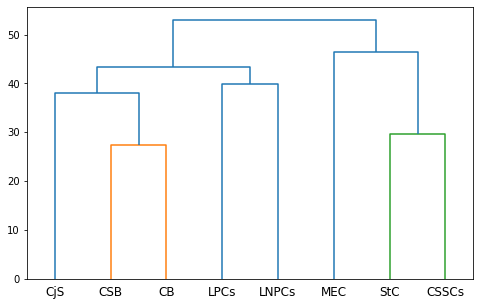

In [4]:
# from numpy.random import rand
X = data2.T.values #Transpose values 
Y = pdist(X)
Z = linkage(Y)
plt.figure(figsize=(8, 5))
dendrogram(Z, labels = data2.columns)

In [11]:
# from console: ipython -pylab
from matplotlib.pyplot import show
dendrogram(Z, labels = data2.columns)
show()

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [35.0, 35.0, 45.0, 45.0],
  [25.0, 25.0, 40.0, 40.0],
  [10.0, 10.0, 32.5, 32.5],
  [55.0, 55.0, 65.0, 65.0],
  [75.0, 75.0, 85.0, 85.0],
  [60.0, 60.0, 80.0, 80.0],
  [95.0, 95.0, 105.0, 105.0],
  [70.0, 70.0, 100.0, 100.0],
  [21.25, 21.25, 85.0, 85.0]],
 'dcoord': [[0.0, 36.99994217145021, 36.99994217145021, 0.0],
  [0.0, 29.566755195138295, 29.566755195138295, 0.0],
  [0.0, 40.428720666945814, 40.428720666945814, 29.566755195138295],
  [36.99994217145021,
   40.863394059013686,
   40.863394059013686,
   40.428720666945814],
  [0.0, 17.294676154105062, 17.294676154105062, 0.0],
  [0.0, 27.39946300119071, 27.39946300119071, 0.0],
  [17.294676154105062,
   37.75486206513979,
   37.75486206513979,
   27.39946300119071],
  [0.0, 39.82675032336912, 39.82675032336912, 0.0],
  [37.75486206513979, 43.32125772595112, 43.32125772595112, 39.82675032336912],
  [40.863394059013686,
   51.29496473968295,
   51.29496473968295,
   43.32125772595112]],
 'ivl': [

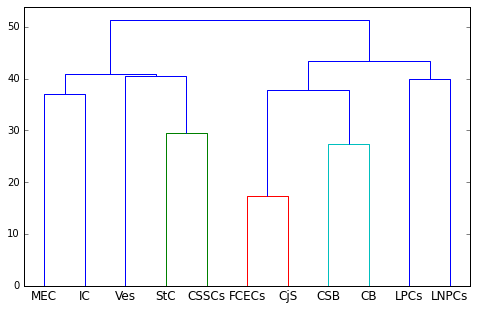

In [35]:
data3 = pd.read_csv('/ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data/lako2021/motif_analysis/vst_nosplit/final.out.txt', sep='\t', header=0)
data3
import numpy as np
from pandas import *
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist


data3.index = data['Unnamed: 0']
data3
data4 = data[['z-score Ves','z-score StC','z-score MEC','z-score LPCs','z-score LNPCs','z-score IC','z-score FCECs','z-score CjS','z-score CSSCs','z-score CSB','z-score CB']]
data4
data4 = data4.rename(columns={'z-score Ves':'Ves', 'z-score StC': 'StC','z-score MEC':'MEC','z-score LPCs':'LPCs','z-score LNPCs':'LNPCs','z-score IC':'IC','z-score FCECs':'FCECs','z-score CjS':'CjS','z-score CSSCs':'CSSCs','z-score CSB':'CSB','z-score CB':'CB'})

X = data4.T.values #Transpose values 
Y = pdist(X)
Z = linkage(Y)
plt.figure(figsize=(8, 5))
dendrogram(Z, labels = data4.columns)